In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from pathlib import Path

In [2]:
import random
import torch
import os
# Seed 고정
SEED = 42   
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
# from catboost import CatBoostClassifier, Pool
from collections import defaultdict

## Data Load

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# train = pd.read_csv('/content/drive/MyDrive/2023/F_W/project/HD/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/2023/F_W/project/HD/test.csv')|


In [5]:
train[train.columns[train.isnull().any()]].shape

(367441, 8)

In [6]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           367441 non-null  object 
 1   ARI_CO              367441 non-null  object 
 2   ARI_PO              367441 non-null  object 
 3   SHIP_TYPE_CATEGORY  367441 non-null  object 
 4   DIST                367441 non-null  float64
 5   ATA                 367441 non-null  object 
 6   ID                  367441 non-null  object 
 7   BREADTH             367440 non-null  float64
 8   BUILT               367441 non-null  int64  
 9   DEADWEIGHT          367441 non-null  int64  
 10  DEPTH               367440 non-null  float64
 11  DRAUGHT             367440 non-null  float64
 12  GT                  367441 non-null  int64  
 13  LENGTH              367440 non-null  float64
 14  SHIPMANAGER         367441 non-null  object 
 15  FLAG                367441 non-nul

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244989 entries, 0 to 244988
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           244989 non-null  object 
 1   ARI_CO              244989 non-null  object 
 2   ARI_PO              244989 non-null  object 
 3   SHIP_TYPE_CATEGORY  244989 non-null  object 
 4   DIST                244989 non-null  float64
 5   ATA                 244989 non-null  object 
 6   ID                  244989 non-null  object 
 7   BREADTH             244989 non-null  float64
 8   BUILT               244989 non-null  int64  
 9   DEADWEIGHT          244989 non-null  int64  
 10  DEPTH               244989 non-null  float64
 11  DRAUGHT             244989 non-null  float64
 12  GT                  244989 non-null  int64  
 13  LENGTH              244989 non-null  float64
 14  SHIPMANAGER         244989 non-null  object 
 15  FLAG                244989 non-nul

None

In [7]:
display(train[train.columns[train.isnull().any()]].info())
display(test[test.columns[test.isnull().any()]].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BREADTH          367440 non-null  float64
 1   DEPTH            367440 non-null  float64
 2   DRAUGHT          367440 non-null  float64
 3   LENGTH           367440 non-null  float64
 4   U_WIND           213955 non-null  float64
 5   V_WIND           213955 non-null  float64
 6   AIR_TEMPERATURE  213076 non-null  float64
 7   BN               213955 non-null  float64
dtypes: float64(8)
memory usage: 22.4 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244989 entries, 0 to 244988
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   U_WIND           143062 non-null  float64
 1   V_WIND           143062 non-null  float64
 2   AIR_TEMPERATURE  142478 non-null  float64
 3   BN               143062 non-null  float64
dtypes: float64(4)
memory usage: 7.5 MB


None

## Data Preprocessing

결측치 처리

In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

BREADTH 와 DEPTH는 ``simpleimputer`` 를 사용하여 평균값으로 대체

In [9]:
from sklearn.impute import SimpleImputer

# 결측값을 중앙값으로 대체하는 SimpleImputer 생성
imputer = SimpleImputer(strategy="mean")

shame = ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH', 'AIR_TEMPERATURE']

train[shame] = imputer.fit_transform(train[shame])
train[shame] = np.round(train[shame])

print(train['BREADTH'].isnull().sum(), train['DEPTH'].isnull().sum(), train['DRAUGHT'].isnull().sum(), train['LENGTH'].isnull().sum())

0 0 0 0


In [10]:
test[shame] = imputer.fit_transform(test[shame])
test[shame] = np.round(test[shame])

#### `U_WIND`, `V_WIND` 결측치 대체
- **`IterativeImputer`** 를 사용하여 결측치 대체

In [13]:
from sklearn.linear_model import Lasso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 대체할 열의 이름을 'Estimated_Departure_Time' 및 'Estimated_Arrival_Time'으로 정의합니다.
wind = ['U_WIND', 'V_WIND']

# IterativeImputer 객체를 생성합니다.
# - Lasso() 추정기(예측 모델)를 사용하여 누락된 값을 대체합니다.
# - 초기 전략은 'most_frequent'로 설정됩니다. (가장 자주 나오는 값으로 초기화)
# - missing_values 매개변수를 사용하여 결측치를 지정합니다.
# - max_iter 매개변수를 사용하여 최대 반복 횟수를 1000으로 설정합니다.
# - imputation_order는 'roman'으로 설정되어 순서대로 대체합니다.
# - random_state는 SEED(임의의 시드 값)로 설정되어 랜덤성을 제어합니다.
imp = IterativeImputer(estimator=Lasso(), initial_strategy='most_frequent', missing_values=np.nan,
                       max_iter=1000, imputation_order='roman', random_state=SEED)

# IterativeImputer를 사용하여 누락된 값을 대체하고, 그 결과를 train 데이터프레임의 해당 열에 할당합니다.
train[wind] = imp.fit_transform(train[wind])

# 대체된 값을 반올림하여 정수로 변환합니다.
#train[estimated_time_col] = np.round(train[estimated_time_col])

# 대체 후에 'Estimated_Departure_Time' 및 'Estimated_Arrival_Time' 열에서 여전히 결측치인 행의 수를 출력합니다.
print(train['V_WIND'].isnull().sum(), train['U_WIND'].isnull().sum())

0 0


In [14]:
test[wind] = imp.fit_transform(test[wind])

`BN` 결측치 대체

![image.png](attachment:image.png)
위 식을 이용하여 BN값 대체

In [15]:
train[['V_WIND', 'U_WIND', 'BN']]

,V_WIND,U_WIND,BN
0,3.770000,0.140000,2.730798
1,-6.720000,-3.160000,4.289058
2,0.000000,0.000000,0.000000
3,-7.310000,4.340000,4.693735
4,2.310000,1.920000,2.345875
...,...,...,...
367436,-0.262955,-0.297586,NaN
367437,0.870000,-0.060000,1.028558
367438,3.360000,-0.630000,2.557156
367439,-2.440000,3.740000,3.055715


In [16]:
train['BN'].fillna(np.power((abs(train['V_WIND']) / 0.836), 2/3), inplace=True)
test['BN'].fillna(np.power((abs(test['V_WIND']) / 0.836), 2/3), inplace=True)

### Feature Engineering

In [17]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

### `season` 변수 생성

In [12]:
# def Get_Season(x) :
#     if x in [12, 1, 2] :
#         return 'Winter'
#     elif x in [3, 4, 5] :
#         return 'Spring'
#     elif x in [6, 7, 8] :
#         return 'Summer'
#     else :
#         return 'Fall'

# train['Season'] = train['month'].apply(Get_Season)

### `범주형` 변수들 인코딩

In [18]:
from sklearn.preprocessing import OrdinalEncoder

cat = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']

ordinal_encoder = OrdinalEncoder()
train[cat] = ordinal_encoder.fit_transform(train[cat])

# housing_cat 데이터를 OrdinalEncoder를 사용하여 변환합니다.
# OrdinalEncoder는 범주형 데이터를 숫자로 인코딩하는데 사용됩니다.

In [19]:
test[cat] = ordinal_encoder.fit_transform(test[cat])

In [20]:
ordinal_encoder.categories_

[array(['AU', 'BR', 'CA', 'CL', 'CN', 'FI', 'ID', 'IN', 'JP', 'KR', 'LV',
        'MY', 'MZ', 'PE', 'PH', 'QA', 'RU', 'SG', 'TT', 'TW', 'UA', 'US',
        'VE', 'VN', 'ZA'], dtype=object),
 array(['AIB7', 'AZU6', 'BAZ5', 'BGD2', 'BGX4', 'CEI5', 'CSP6', 'CXL1',
        'DEJ2', 'DIN2', 'DMD4', 'EFG4', 'EIA2', 'EKP8', 'EUC8', 'EVL6',
        'EVX2', 'FAV3', 'FCD5', 'FFM2', 'FTQ1', 'GIW5', 'GQJ7', 'GRQ5',
        'HGH2', 'HYG5', 'HYV6', 'IEW6', 'IVU2', 'JDG8', 'JEA6', 'JEN5',
        'JER7', 'JGL5', 'JTD1', 'JWI3', 'KIU2', 'KSF1', 'LHD1', 'LXJ7',
        'MCG4', 'MIA8', 'MMW5', 'MOC5', 'NCU8', 'NGG6', 'NNC2', 'NQO4',
        'OBZ3', 'OKM4', 'ONW1', 'OOV8', 'OZD2', 'PAF4', 'PBQ1', 'PDL4',
        'PEL6', 'PPM2', 'PUF3', 'QEA4', 'QGL7', 'QGN3', 'QQW1', 'QRN3',
        'QTU5', 'QXE2', 'QYY1', 'REJ1', 'RGT8', 'RKA2', 'SLZ5', 'SPG1',
        'SXD2', 'TBL3', 'TDA5', 'TMR7', 'TMW2', 'TXO3', 'TYY2', 'UEW5',
        'UIR7', 'UJM2', 'UPI6', 'URD4', 'URE2', 'UVK6', 'VFD8', 'VXM8',
        'VYJ1', 'W

In [21]:
train[cat]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,ID,SHIPMANAGER,FLAG
0,4.0,13.0,0.0,24337.0,591.0,18.0
1,4.0,14.0,2.0,19552.0,723.0,100.0
2,4.0,45.0,2.0,20449.0,2199.0,65.0
3,8.0,75.0,1.0,1689.0,3226.0,79.0
4,16.0,46.0,2.0,2989.0,3723.0,87.0
...,...,...,...,...,...,...
367436,4.0,100.0,0.0,9173.0,933.0,65.0
367437,8.0,66.0,3.0,3778.0,3769.0,57.0
367438,17.0,21.0,2.0,15882.0,2396.0,25.0
367439,8.0,75.0,1.0,12466.0,5069.0,57.0


In [22]:
train[['SHIP_TYPE_CATEGORY']]

,SHIP_TYPE_CATEGORY
0,0.0
1,2.0
2,2.0
3,1.0
4,2.0
...,...
367436,0.0
367437,3.0
367438,2.0
367439,1.0


In [23]:
train.drop(columns='SAMPLE_ID', inplace=True)
test.drop(columns='SAMPLE_ID', inplace=True)

In [25]:
test.shape

(244989, 30)

# 여기까지가 결측치 처리, 범주형 변수 처리

### EDA

In [366]:
# # Categorical 컬럼 인코딩
# categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
# encoders = {}

# for feature in tqdm(categorical_features, desc="Encoding features"):
#     le = LabelEncoder()
#     train[feature] = le.fit_transform(train[feature].astype(str))
#     le_classes_set = set(le.classes_)
#     test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
#     le_classes = le.classes_.tolist()
#     bisect.insort_left(le_classes, '-1')
#     le.classes_ = np.array(le_classes)
#     test[feature] = le.transform(test[feature].astype(str))
#     encoders[feature] = le

## modeling

In [367]:
sample_submission = pd.read_csv('/content/drive/MyDrive/2023/F_W/project/HD/sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/2023/F_W/project/HD/sample_submission.csv'

In [335]:
train.ID

0         24337.0
1         19552.0
2         20449.0
3          1689.0
4          2989.0
           ...   
367436     9173.0
367437     3778.0
367438    15882.0
367439    12466.0
367440    20748.0
Name: ID, Length: 367441, dtype: float64

In [336]:
test.columns

Index(['SAMPLE_ID', 'ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'year',
       'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

In [404]:
train.drop(columns='SAMPLE_ID', inplace=True)
test.drop(columns='SAMPLE_ID', inplace=True)

In [338]:
train_labeled = train[train['CI_HOUR'].notnull()]
train_unlabeled = train[train['CI_HOUR'].isnull()]

train_labeled['CI_HOUR'] = train_labeled['CI_HOUR'].astype('int16')
counts = list(train_labeled['CI_HOUR'].value_counts())
class_weight = [counts[1] / sum(counts), counts[0] / sum(counts)]
class_weight_dict = dict(enumerate(class_weight))
print('Weight : ', class_weight)

Weight :  [0.015814783870063492, 0.41484211070620863]


In [28]:
X_data, y_data = train_labeled.drop('CI_HOUR', axis = 1), train_labeled['CI_HOUR']
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.2,
                                                      random_state = SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(293952, 25) (73489, 25) (293952,) (73489,)


### xgboost

In [127]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor()

parameters = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [500, 1000, 1500, 2000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'subsample': [0.5, 0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'random_sate':[2],
    'tree_method':["gpu_hist"]
}   

xgb_grid = GridSearchCV(xgb, parameters, cv=5, n_jobs=5, verbose=5, scoring='neg_mean_absolute_error')

xgb_grid.fit(X_train, y_train)
scores = pd.DataFrame(xgb_grid.cv_results_)
scores[['params','mean_test_score', 'rank_test_score', 'split0_test_score','split1_test_score', 'split2_test_score']]

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

-29.53198762037701
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 2000, 'random_sate': 2, 'subsample': 0.8, 'tree_method': 'gpu_hist'}


In [124]:
from sklearn.metrics import accuracy_score
xgbBest = xgb_grid.best_estimator_
scores = pd.DataFrame(xgb_grid.cv_results_)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', 21)
scores.info()

print(scores.sort_values(by=scores.columns[20], ascending=True).head(10))

NameError: name 'xgb_grid' is not defined

In [282]:
myxgb = XGBRegressor(objective='reg:squarederror',colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=1000, n_thread= 4, random_state=2, subsample=0.8)
myxgb.fit(X_train, y_train)

c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, n_thread=4,
             num_parallel_tree=None, ...)

Model Tune for XGBSOOT.


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

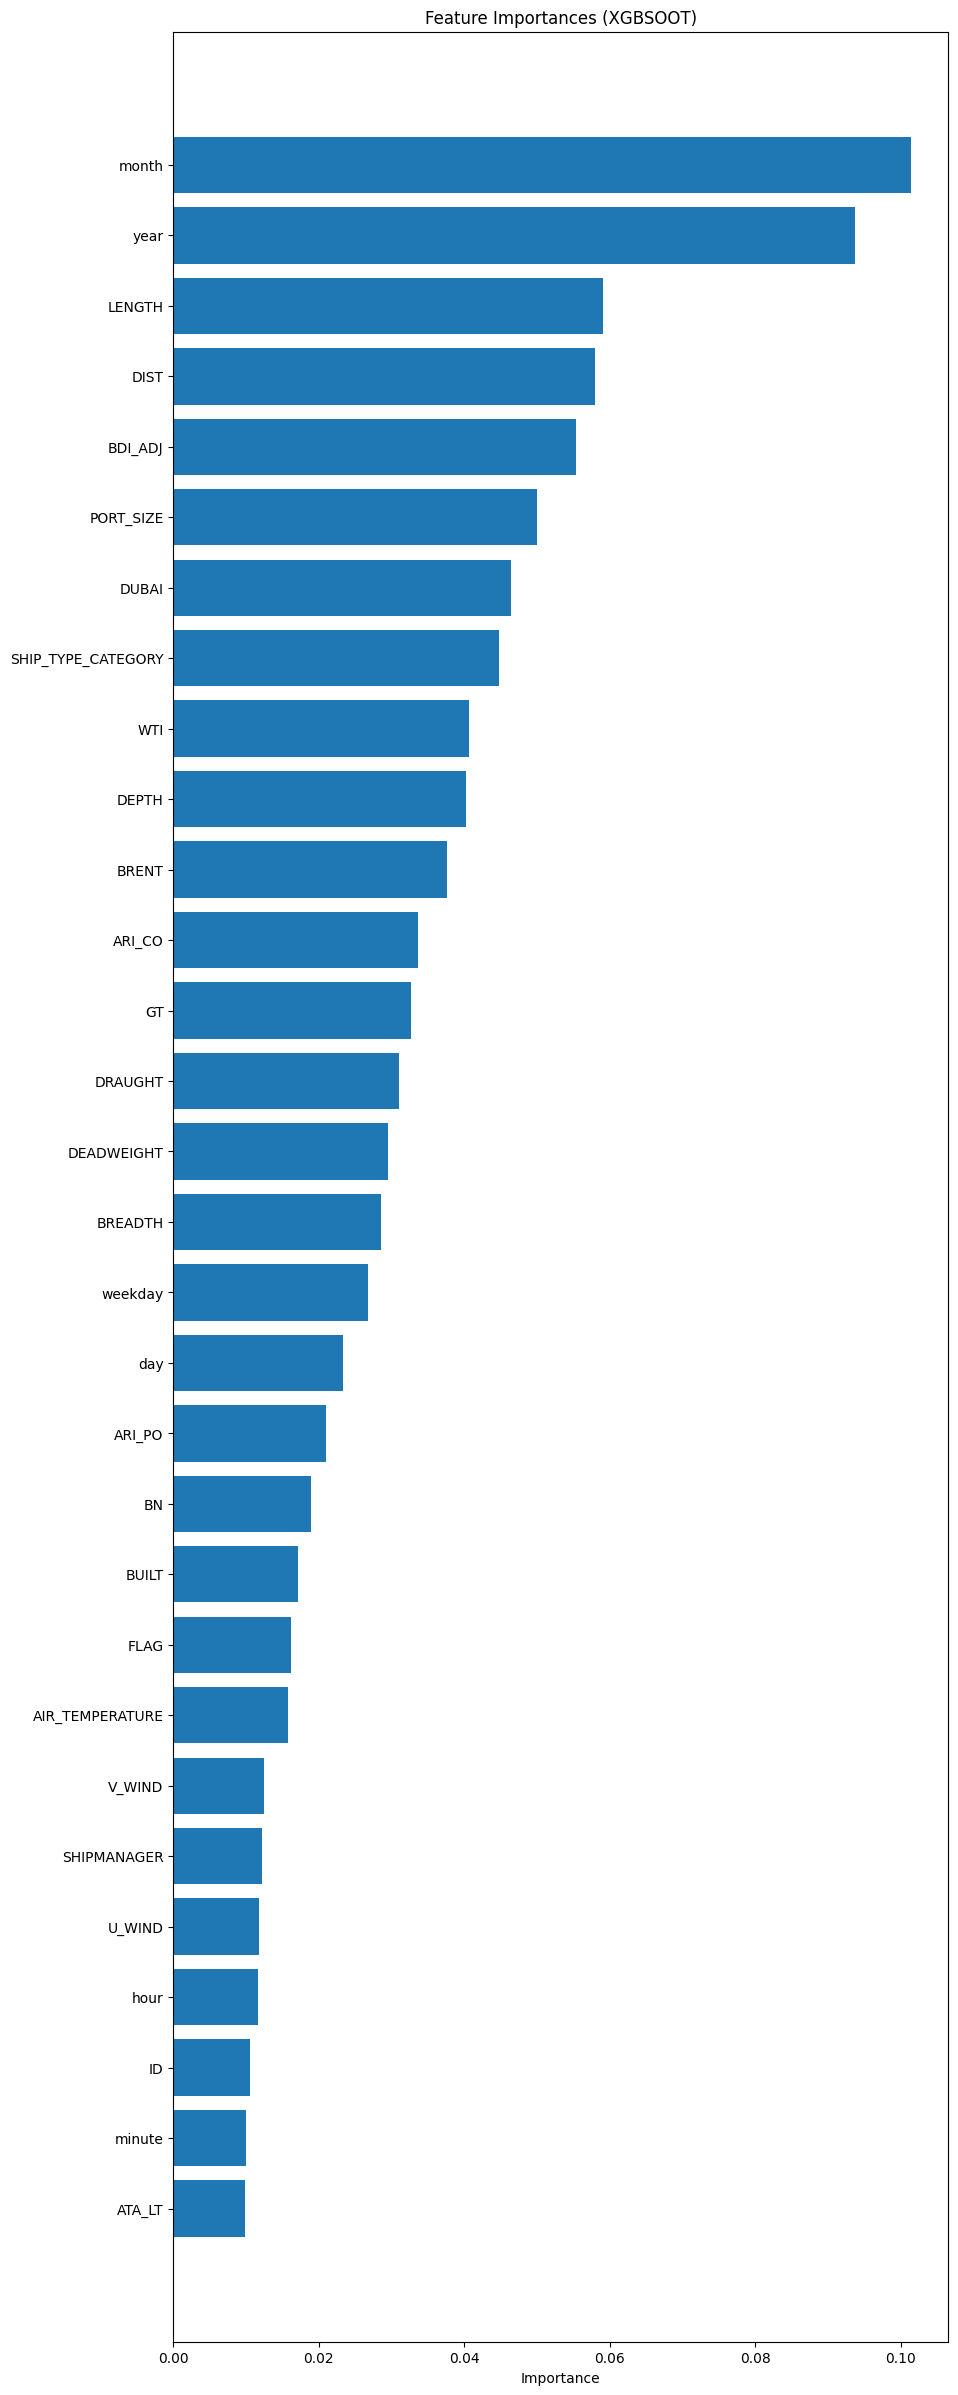

In [52]:
from xgboost import XGBRegressor


def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
xgb_model, xgb_feature_importances = train_and_evaluate(XGBRegressor(objective='reg:squarederror', booster='dart',
                                                                     colsample_bytree=0.8206010877469909, 
                                                                     learning_rate=0.09722201341469268, 
                                                                     max_depth=7,n_estimators=3985,
                                                                             subsample=0.9534412970376984, tree_method='gpu_hist' 
                                                                             ), 'XGBSOOT', X_train, y_train)

In [53]:
threshold = 0.021 # Your Threshold
low_importance_features = X_train.columns[xgb_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [ ]:
test

In [54]:
low_importance_features

Index(['ARI_PO', 'ID', 'BUILT', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'hour', 'minute'],
      dtype='object')

In [57]:
xgbs = XGBRegressor(objective='reg:squarederror', booster='dart',
                                                                     colsample_bytree=0.8206010877469909, 
                                                                     learning_rate=0.09722201341469268, 
                                                                     max_depth=7,n_estimators=3985,
                                                                             subsample=0.9534412970376984, tree_method='gpu_hist')

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    xgbs.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgbs.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    mae_scores.append(mean_absolute_error(y_val, val_pred))
    mse_scores.append(mean_squared_error(y_val, val_pred))
    rmse_scores.append(mean_squared_error(y_val, val_pred, squared=False))
    r2_scores.append(r2_score(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    xgbs_pred = xgbs.predict(X_test_reduced)
    xgbs_pred = np.where(xgbs_pred < 0, 0, xgbs_pred)

    ensemble_predictions.append(xgbs_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", mae_scores)
print("Validation : MAE:", np.mean(mae_scores))
print("Validation : MSE:", np.mean(mse_scores))
print("Validation : RMSE:", np.mean(rmse_scores))
print("Validation : R2:", np.mean(r2_scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

Validation : MAE scores for each fold: [19.652478945687083, 20.432453115726158, 20.3643317785075, 20.1777184565736, 20.203716174378556]
Validation : MAE: 20.16613969417458
Validation : MSE: 3723.9424623684995
Validation : RMSE: 61.0104243784658
Validation : R2: 0.8720586958066278


In [58]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./xgboost20_submit.csv', index=False)

Model Tune for XGBSOOT.


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

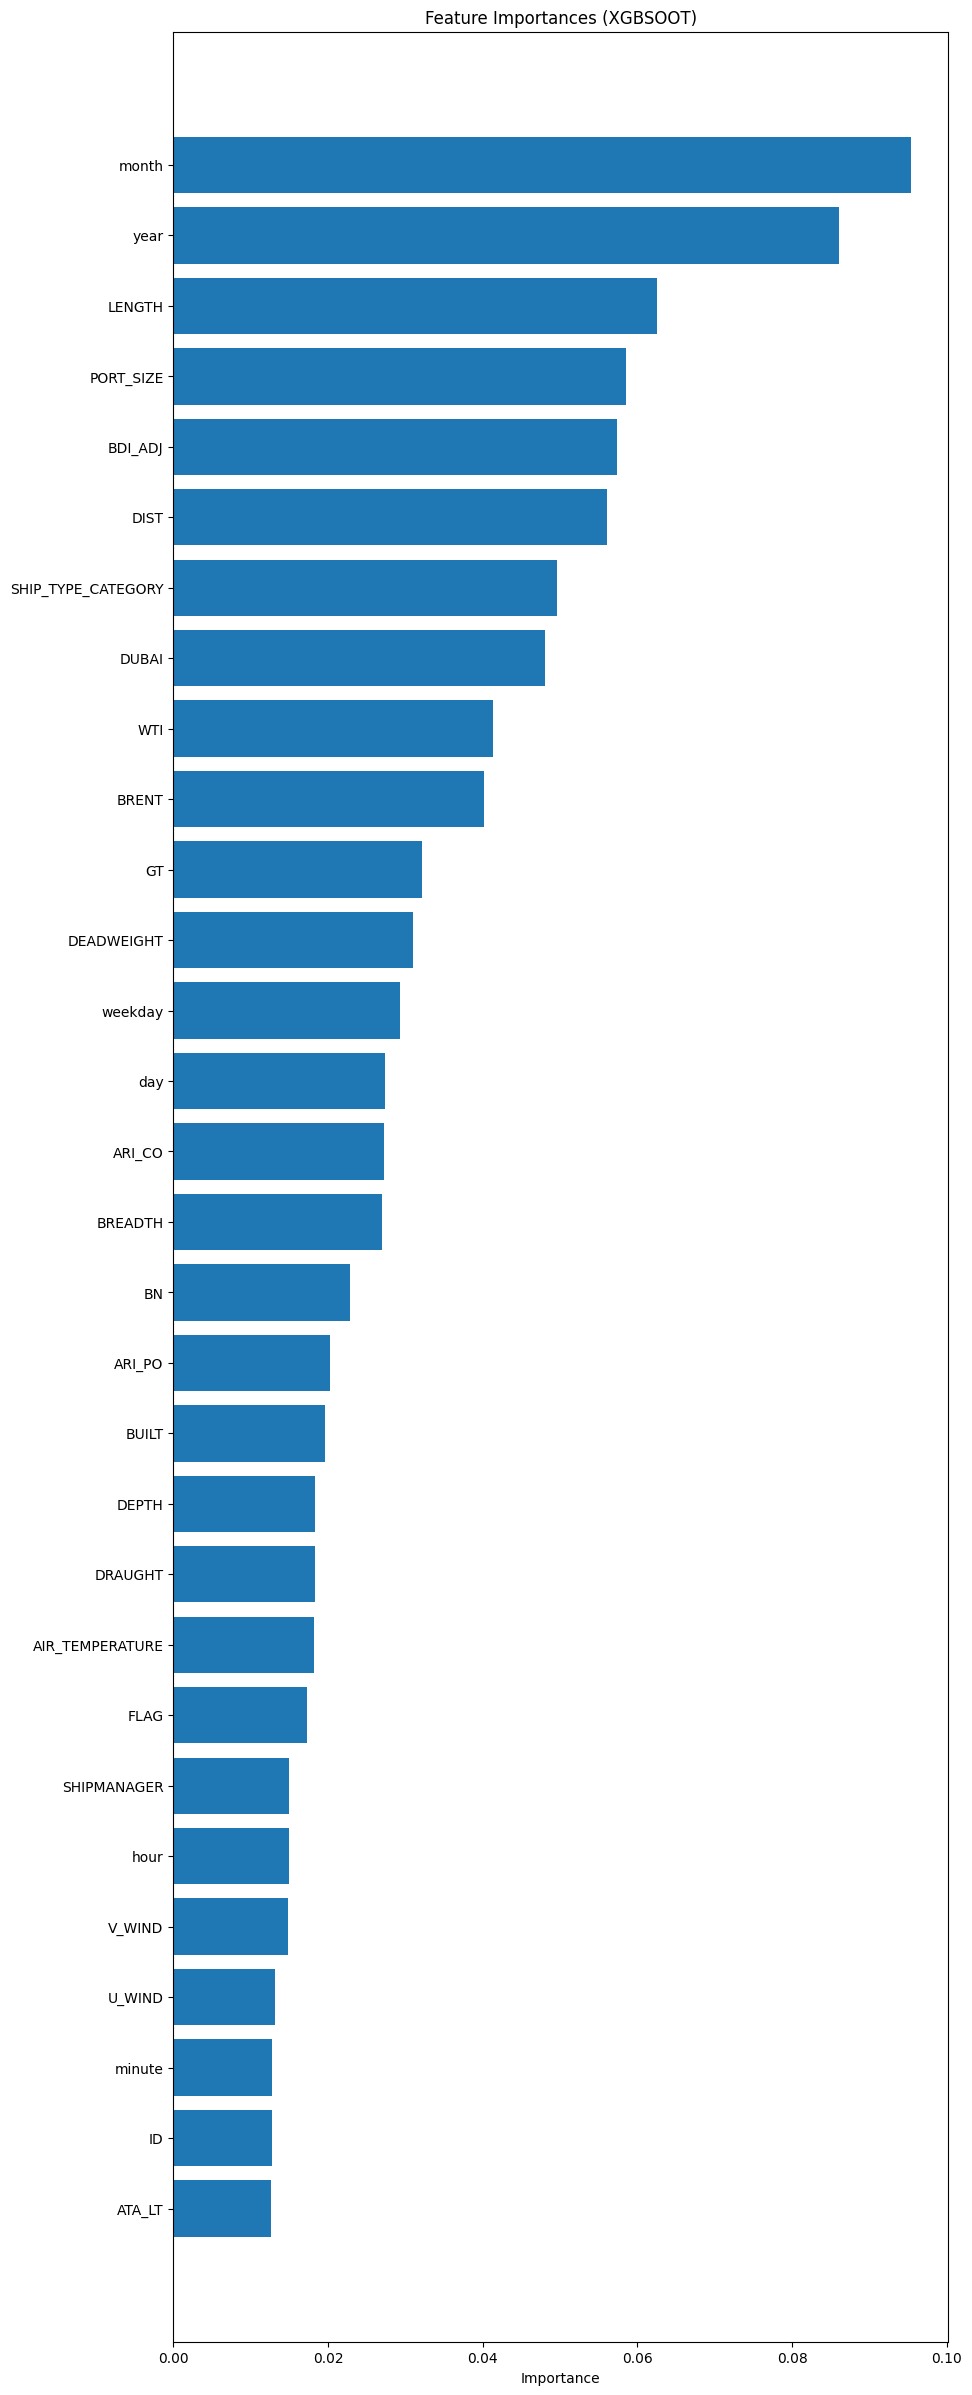

In [25]:
from xgboost import XGBRegressor


def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
xgb_model, xgb_feature_importances = train_and_evaluate(XGBRegressor(objective='reg:squarederror',
                                                                     booster='dart',
                                                                     colsample_bytree=0.9, 
                                                                     learning_rate=0.1, 
                                                                     max_depth=7, min_child_weight=1,
                                                                       n_estimators=2000,
                                                                           random_state=2,
                                                                             subsample=0.8, tree_method='gpu_hist'
                                                                            ), 'XGBSOOT', X_train, y_train)

In [34]:
threshold = 0.0185 # Your Threshold
low_importance_features = X_train.columns[xgb_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [35]:
low_importance_features

Index(['ID', 'DEPTH', 'DRAUGHT', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'ATA_LT', 'hour', 'minute'],
      dtype='object')

In [39]:
xgbs = XGBRegressor(objective='reg:squarederror', booster='dart', colsample_bytree=0.9, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=2000, tree_method='gpu_hist')

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    xgbs.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgbs.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    mae_scores.append(mean_absolute_error(y_val, val_pred))
    mse_scores.append(mean_squared_error(y_val, val_pred))
    rmse_scores.append(mean_squared_error(y_val, val_pred, squared=False))
    r2_scores.append(r2_score(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    xgbs_pred = xgbs.predict(X_test_reduced)
    xgbs_pred = np.where(xgbs_pred < 0, 0, xgbs_pred)

    ensemble_predictions.append(xgbs_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", mae_scores)
print("Validation : MAE:", np.mean(mae_scores))
print("Validation : MSE:", np.mean(mse_scores))
print("Validation : RMSE:", np.mean(rmse_scores))
print("Validation : R2:", np.mean(r2_scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

Validation : MAE scores for each fold: [24.06079787726638, 24.847737459778603, 24.81010080066236, 24.09139511010348, 24.793924849105398]
Validation : MAE: 24.52079121938324
Validation : MSE: 4739.343336490536
Validation : RMSE: 68.8277004855697
Validation : R2: 0.8371756307162567


In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

In [145]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./xgboost_middel_submit.csv', index=False)

## CATBOOST

Model Tune for CATBOOST.
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3729
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


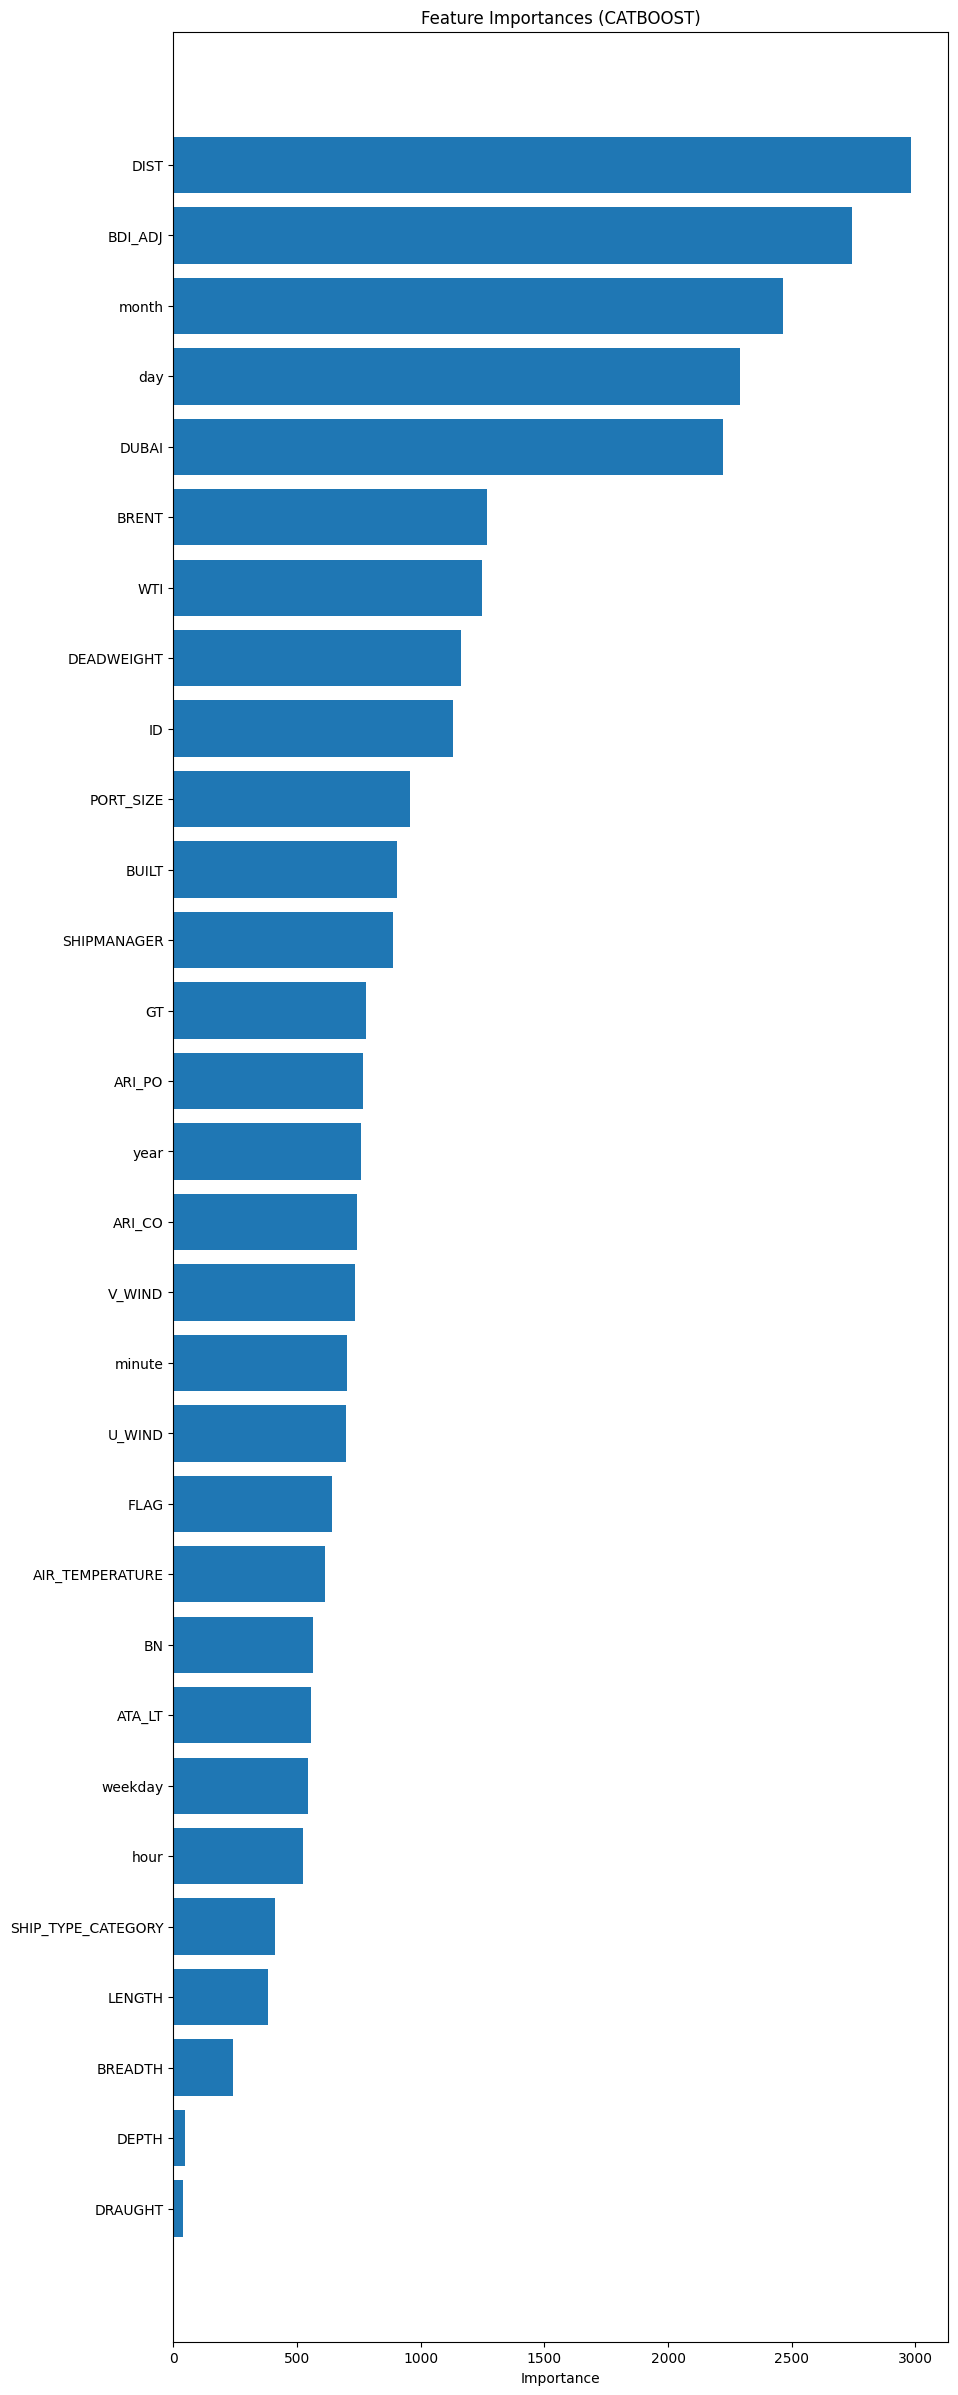

In [94]:
X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(colsample_bylevel = 0.7, depth = 7, learning_rate= 0.1, min_child_samples= 1, n_estimators = 1000, random_state = 2, subsample = 0.8), 'CATBOOST', X_train, y_train)

In [31]:
threshold = 500 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [34]:
catboost = cb.CatBoostRegressor(colsample_bylevel = 0.7, depth = 7, learning_rate= 0.1, min_child_samples= 1, n_estimators = 1000, random_state = 2, subsample = 0.8)


# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    catboost.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = catboost.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    CB_pred = catboost.predict(X_test_reduced)
    CB_pred = np.where(CB_pred < 0, 0, CB_pred)

    ensemble_predictions.append(CB_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 168.2744886	total: 11.7ms	remaining: 11.7s
1:	learn: 166.2016991	total: 22.5ms	remaining: 11.2s
2:	learn: 164.3978323	total: 33.6ms	remaining: 11.2s
3:	learn: 162.7282047	total: 44.3ms	remaining: 11s
4:	learn: 161.3370783	total: 55ms	remaining: 11s
5:	learn: 160.2600642	total: 66ms	remaining: 10.9s
6:	learn: 159.2791227	total: 76.6ms	remaining: 10.9s
7:	learn: 158.5017699	total: 87.5ms	remaining: 10.8s
8:	learn: 157.7836756	total: 98.2ms	remaining: 10.8s
9:	learn: 157.1628367	total: 109ms	remaining: 10.8s
10:	learn: 156.4879549	total: 120ms	remaining: 10.8s
11:	learn: 156.0046142	total: 130ms	remaining: 10.7s
12:	learn: 155.6573349	total: 141ms	remaining: 10.7s
13:	learn: 155.0141018	total: 152ms	remaining: 10.7s
14:	learn: 154.5833592	total: 163ms	remaining: 10.7s
15:	learn: 154.2208358	total: 174ms	remaining: 10.7s
16:	learn: 153.8801780	total: 185ms	remaining: 10.7s
17:	learn: 153.5920746	total: 197ms	remaining: 10.7s
18:	learn: 153.2633877	total: 208ms	remaining: 10.8s
19

Processing folds:  20%|██        | 1/5 [00:12<00:49, 12.38s/it]

998:	learn: 90.9347457	total: 12.1s	remaining: 12.1ms
999:	learn: 90.8613197	total: 12.1s	remaining: 0us
0:	learn: 167.4689936	total: 12.5ms	remaining: 12.4s
1:	learn: 165.4174807	total: 23.6ms	remaining: 11.8s
2:	learn: 163.5689504	total: 34.9ms	remaining: 11.6s
3:	learn: 161.9992175	total: 46.4ms	remaining: 11.6s
4:	learn: 160.6799752	total: 58.1ms	remaining: 11.6s
5:	learn: 159.5386387	total: 69.6ms	remaining: 11.5s
6:	learn: 158.5846737	total: 81.4ms	remaining: 11.5s
7:	learn: 157.7633482	total: 93.2ms	remaining: 11.6s
8:	learn: 157.0391223	total: 105ms	remaining: 11.6s
9:	learn: 156.4054916	total: 117ms	remaining: 11.5s
10:	learn: 155.7679536	total: 129ms	remaining: 11.6s
11:	learn: 155.2122122	total: 147ms	remaining: 12.1s
12:	learn: 154.8632139	total: 159ms	remaining: 12.1s
13:	learn: 154.4544443	total: 171ms	remaining: 12s
14:	learn: 154.0627625	total: 182ms	remaining: 12s
15:	learn: 153.6581689	total: 193ms	remaining: 11.9s
16:	learn: 153.3702656	total: 205ms	remaining: 11.9s


Processing folds:  40%|████      | 2/5 [00:24<00:36, 12.32s/it]

0:	learn: 167.6383490	total: 12.6ms	remaining: 12.6s
1:	learn: 165.5916835	total: 23.6ms	remaining: 11.8s
2:	learn: 163.7119596	total: 36.2ms	remaining: 12s
3:	learn: 162.0948122	total: 47.2ms	remaining: 11.7s
4:	learn: 160.8227297	total: 58ms	remaining: 11.5s
5:	learn: 159.6948921	total: 69.1ms	remaining: 11.5s
6:	learn: 158.7071024	total: 80.8ms	remaining: 11.5s
7:	learn: 157.9520447	total: 92.4ms	remaining: 11.5s
8:	learn: 157.1799684	total: 104ms	remaining: 11.4s
9:	learn: 156.5893668	total: 115ms	remaining: 11.4s
10:	learn: 155.9247758	total: 126ms	remaining: 11.4s
11:	learn: 155.4393654	total: 138ms	remaining: 11.4s
12:	learn: 155.0908995	total: 150ms	remaining: 11.4s
13:	learn: 154.6036034	total: 162ms	remaining: 11.4s
14:	learn: 154.2601625	total: 173ms	remaining: 11.4s
15:	learn: 153.9016925	total: 184ms	remaining: 11.3s
16:	learn: 153.5492340	total: 196ms	remaining: 11.3s
17:	learn: 153.2895523	total: 208ms	remaining: 11.3s
18:	learn: 152.9932838	total: 220ms	remaining: 11.3s

Processing folds:  60%|██████    | 3/5 [00:37<00:24, 12.37s/it]

0:	learn: 168.3511468	total: 12.6ms	remaining: 12.6s
1:	learn: 166.2907512	total: 25.3ms	remaining: 12.6s
2:	learn: 164.4088767	total: 37.3ms	remaining: 12.4s
3:	learn: 162.8064524	total: 49.4ms	remaining: 12.3s
4:	learn: 161.4887882	total: 60.9ms	remaining: 12.1s
5:	learn: 160.3447424	total: 72.7ms	remaining: 12s
6:	learn: 159.3921056	total: 84.5ms	remaining: 12s
7:	learn: 158.5750274	total: 96.1ms	remaining: 11.9s
8:	learn: 157.8595088	total: 107ms	remaining: 11.8s
9:	learn: 157.2310194	total: 119ms	remaining: 11.7s
10:	learn: 156.5909239	total: 130ms	remaining: 11.7s
11:	learn: 156.0168558	total: 142ms	remaining: 11.7s
12:	learn: 155.5896039	total: 153ms	remaining: 11.6s
13:	learn: 154.9689607	total: 165ms	remaining: 11.6s
14:	learn: 154.6520876	total: 175ms	remaining: 11.5s
15:	learn: 154.2537218	total: 187ms	remaining: 11.5s
16:	learn: 153.9425012	total: 199ms	remaining: 11.5s
17:	learn: 153.6798636	total: 210ms	remaining: 11.5s
18:	learn: 153.4083722	total: 223ms	remaining: 11.5s

Processing folds:  80%|████████  | 4/5 [00:49<00:12, 12.25s/it]

998:	learn: 90.7689557	total: 11.7s	remaining: 11.8ms
999:	learn: 90.7571342	total: 11.8s	remaining: 0us
0:	learn: 168.0290166	total: 11.2ms	remaining: 11.2s
1:	learn: 165.9721993	total: 22.8ms	remaining: 11.4s
2:	learn: 164.1415226	total: 33.7ms	remaining: 11.2s
3:	learn: 162.4881115	total: 45.5ms	remaining: 11.3s
4:	learn: 161.1740026	total: 57.7ms	remaining: 11.5s
5:	learn: 160.0736645	total: 91.3ms	remaining: 15.1s
6:	learn: 159.1027711	total: 104ms	remaining: 14.7s
7:	learn: 158.3054765	total: 115ms	remaining: 14.2s
8:	learn: 157.6051894	total: 125ms	remaining: 13.8s
9:	learn: 156.9165269	total: 136ms	remaining: 13.5s
10:	learn: 156.3421547	total: 148ms	remaining: 13.3s
11:	learn: 155.8301131	total: 159ms	remaining: 13.1s
12:	learn: 155.4307317	total: 170ms	remaining: 12.9s
13:	learn: 155.0070145	total: 182ms	remaining: 12.8s
14:	learn: 154.6121110	total: 192ms	remaining: 12.6s
15:	learn: 154.1752246	total: 203ms	remaining: 12.5s
16:	learn: 153.8470237	total: 214ms	remaining: 12.4

Processing folds: 100%|██████████| 5/5 [01:00<00:00, 12.17s/it]

993:	learn: 91.7782325	total: 11.3s	remaining: 68.4ms
994:	learn: 91.7674734	total: 11.3s	remaining: 57ms
995:	learn: 91.7545762	total: 11.4s	remaining: 45.6ms
996:	learn: 91.7195275	total: 11.4s	remaining: 34.2ms
997:	learn: 91.7139483	total: 11.4s	remaining: 22.8ms
998:	learn: 91.7049875	total: 11.4s	remaining: 11.4ms
999:	learn: 91.6212839	total: 11.4s	remaining: 0us
Validation : MAE scores for each fold: [40.885337948085414, 41.90079015287729, 41.61818152208108, 41.60347164444669, 41.5501158593222]
Validation : MAE: 41.51157942536254


## Light-BGM

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


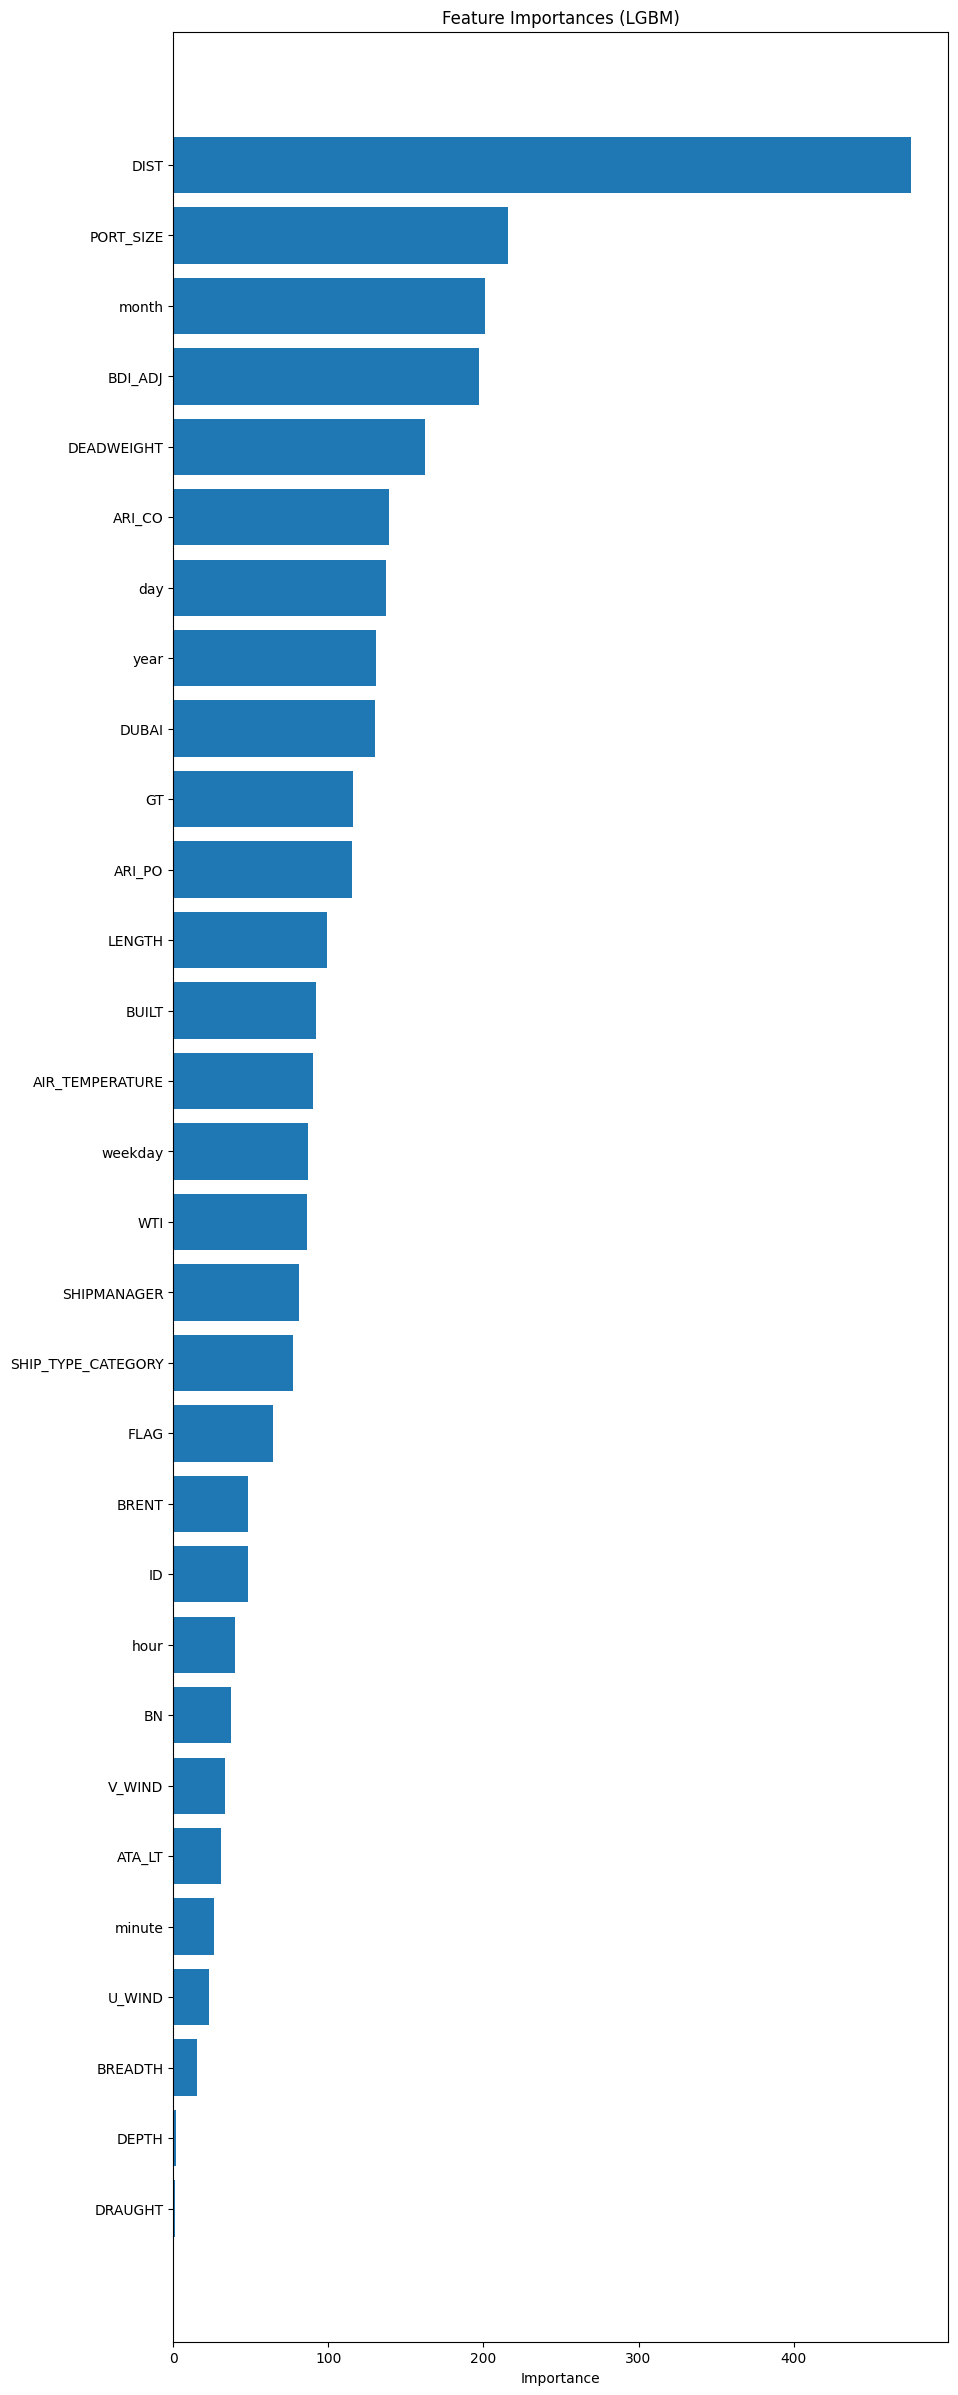

In [339]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [24]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train
X_test_reduced = test

NameError: name 'low_importance_features' is not defined

In [341]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 16
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:02<00:08,  2.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:04<00:06,  2.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:06<00:04,  2.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:08<00:02,  2.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 16
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

Validation : MAE scores for each fold: [52.868839877855734, 53.716518171456194, 53.66509760758469, 53.814993921759026, 53.27612153713105]
Validation : MAE: 53.468314223157336


In [343]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./aaa3_submit.csv', index=False)

### xgboost, lgbm ensemble

In [389]:
y_train

0          3.048333
1         17.138611
2         98.827500
3          0.000000
4         96.030556
            ...    
367436    65.850000
367437     0.000000
367438     0.997500
367439     0.000000
367440     8.464167
Name: CI_HOUR, Length: 367441, dtype: float64

In [394]:
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# LightGBM 및 XGBoost 모델 초기화
lgbm = lgb.LGBMRegressor()
xgboost = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=1000, n_thread= 4, random_state=2, subsample=0.8)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions_lgbm = []
ensemble_predictions_xgboost = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # LightGBM 모델 학습
    lgbm.fit(X_t, y_t)

    # XGBoost 모델 학습
    xgboost.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred_lgbm = lgbm.predict(X_val)
    val_pred_xgboost = xgboost.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores_lgbm = mean_absolute_error(y_val, val_pred_lgbm)
    scores_xgboost = mean_absolute_error(y_val, val_pred_xgboost)

    scores.append((scores_lgbm + scores_xgboost) / 2)  # 두 모델의 MAE를 평균하여 저장

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    xgboost_pred = xgboost.predict(X_test_reduced)
    
    # 예측값을 0 이상으로 만듭니다.
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    xgboost_pred = np.where(xgboost_pred < 0, 0, xgboost_pred)

    ensemble_predictions_lgbm.append(lgbm_pred)
    ensemble_predictions_xgboost.append(xgboost_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions_lgbm = np.mean(ensemble_predictions_lgbm, axis=0)
final_predictions_xgboost = np.mean(ensemble_predictions_xgboost, axis=0)

# LightGBM와 XGBoost의 예측을 평균하여 최종 앙상블 예측 생성
final_predictions = (final_predictions_lgbm + final_predictions_xgboost) / 2

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3933
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 30
[LightGBM] [Info] Start training from score 62.047288


c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3936
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 30
[LightGBM] [Info] Start training from score 61.719969


c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3935
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 30
[LightGBM] [Info] Start training from score 61.754815


c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 30
[LightGBM] [Info] Start training from score 61.868218


c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3932
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 30
[LightGBM] [Info] Start training from score 61.995298


c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

Validation : MAE scores for each fold: [43.361681339162445, 44.96436022118837, 45.07560118155411, 44.60768351029147, 44.1101170634549]
Validation : MAE: 44.42388866313026


## XGBOOST, CATBOOST Ensenble

In [35]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# LightGBM, XGBoost, 및 CatBoost 모델 초기화
lgbm = lgb.LGBMRegressor()
xgboost = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.7, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=1000, n_thread= 4, random_state=2, subsample=0.8)
catboost = cb.CatBoostRegressor(colsample_bylevel = 0.7, depth = 7, learning_rate= 0.1, min_child_samples= 1, n_estimators = 1000, random_state = 2, subsample = 0.8)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions_lgbm = []
ensemble_predictions_xgboost = []
ensemble_predictions_catboost = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # LightGBM 모델 학습
    #lgbm.fit(X_t, y_t)

    # XGBoost 모델 학습
    xgboost.fit(X_t, y_t)

    # CatBoost 모델 학습
    catboost.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    #val_pred_lgbm = lgbm.predict(X_val)
    val_pred_xgboost = xgboost.predict(X_val)
    val_pred_catboost = catboost.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    #scores_lgbm = mean_absolute_error(y_val, val_pred_lgbm)
    scores_xgboost = mean_absolute_error(y_val, val_pred_xgboost)
    scores_catboost = mean_absolute_error(y_val, val_pred_catboost)

    scores.append((scores_xgboost + scores_catboost) / 2)  # 세 모델의 MAE를 평균하여 저장

    # test 데이터셋에 대한 예측 수행 후 저장
    #lgbm_pred = lgbm.predict(X_test_reduced)
    xgboost_pred = xgboost.predict(X_test_reduced)
    catboost_pred = catboost.predict(X_test_reduced)
    
    # 예측값을 0 이상으로 만듭니다.
    #lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    xgboost_pred = np.where(xgboost_pred < 0, 0, xgboost_pred)
    catboost_pred = np.where(catboost_pred < 0, 0, catboost_pred)

    #ensemble_predictions_lgbm.append(lgbm_pred)
    ensemble_predictions_xgboost.append(xgboost_pred)
    ensemble_predictions_catboost.append(catboost_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
#final_predictions_lgbm = np.mean(ensemble_predictions_lgbm, axis=0)
final_predictions_xgboost = np.mean(ensemble_predictions_xgboost, axis=0)
final_predictions_catboost = np.mean(ensemble_predictions_catboost, axis=0)

# LightGBM, XGBoost, 및 CatBoost의 예측을 평균하여 최종 앙상블 예측 생성
final_predictions = (final_predictions_xgboost + final_predictions_catboost) / 2

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

0:	learn: 168.2744886	total: 12.8ms	remaining: 12.8s
1:	learn: 166.2016991	total: 24.5ms	remaining: 12.2s
2:	learn: 164.3978323	total: 35.9ms	remaining: 11.9s
3:	learn: 162.7282047	total: 46.7ms	remaining: 11.6s
4:	learn: 161.3370783	total: 58ms	remaining: 11.5s
5:	learn: 160.2600642	total: 69.3ms	remaining: 11.5s
6:	learn: 159.2791227	total: 80.5ms	remaining: 11.4s
7:	learn: 158.5017699	total: 91.2ms	remaining: 11.3s
8:	learn: 157.7836756	total: 102ms	remaining: 11.3s
9:	learn: 157.1628367	total: 120ms	remaining: 11.8s
10:	learn: 156.4879549	total: 132ms	remaining: 11.8s
11:	learn: 156.0046142	total: 144ms	remaining: 11.9s
12:	learn: 155.6573349	total: 156ms	remaining: 11.9s
13:	learn: 155.0141018	total: 168ms	remaining: 11.8s
14:	learn: 154.5833592	total: 179ms	remaining: 11.8s
15:	learn: 154.2208358	total: 190ms	remaining: 11.7s
16:	learn: 153.8801780	total: 202ms	remaining: 11.7s
17:	learn: 153.5920746	total: 214ms	remaining: 11.7s
18:	learn: 153.2633877	total: 225ms	remaining: 11.

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

0:	learn: 167.4689936	total: 12.4ms	remaining: 12.4s
1:	learn: 165.4174807	total: 24.1ms	remaining: 12s
2:	learn: 163.5689504	total: 36.7ms	remaining: 12.2s
3:	learn: 161.9992175	total: 48.4ms	remaining: 12.1s
4:	learn: 160.6799752	total: 61.1ms	remaining: 12.2s
5:	learn: 159.5386387	total: 74.2ms	remaining: 12.3s
6:	learn: 158.5846737	total: 87.3ms	remaining: 12.4s
7:	learn: 157.7633482	total: 100ms	remaining: 12.4s
8:	learn: 157.0391223	total: 112ms	remaining: 12.3s
9:	learn: 156.4054916	total: 125ms	remaining: 12.3s
10:	learn: 155.7679536	total: 137ms	remaining: 12.4s
11:	learn: 155.2122122	total: 150ms	remaining: 12.3s
12:	learn: 154.8632139	total: 161ms	remaining: 12.2s
13:	learn: 154.4544443	total: 172ms	remaining: 12.1s
14:	learn: 154.0627625	total: 184ms	remaining: 12.1s
15:	learn: 153.6581689	total: 195ms	remaining: 12s
16:	learn: 153.3702656	total: 206ms	remaining: 11.9s
17:	learn: 153.0390308	total: 218ms	remaining: 11.9s
18:	learn: 152.7963105	total: 229ms	remaining: 11.8s


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

0:	learn: 167.6383490	total: 13ms	remaining: 13s
1:	learn: 165.5916835	total: 24ms	remaining: 12s
2:	learn: 163.7119596	total: 35.6ms	remaining: 11.8s
3:	learn: 162.0948122	total: 46.9ms	remaining: 11.7s
4:	learn: 160.8227297	total: 58.4ms	remaining: 11.6s
5:	learn: 159.6948921	total: 69.9ms	remaining: 11.6s
6:	learn: 158.7071024	total: 81.7ms	remaining: 11.6s
7:	learn: 157.9520447	total: 93.6ms	remaining: 11.6s
8:	learn: 157.1799684	total: 105ms	remaining: 11.6s
9:	learn: 156.5893668	total: 116ms	remaining: 11.5s
10:	learn: 155.9247758	total: 128ms	remaining: 11.5s
11:	learn: 155.4393654	total: 140ms	remaining: 11.5s
12:	learn: 155.0908995	total: 152ms	remaining: 11.5s
13:	learn: 154.6036034	total: 164ms	remaining: 11.5s
14:	learn: 154.2601625	total: 176ms	remaining: 11.6s
15:	learn: 153.9016925	total: 188ms	remaining: 11.6s
16:	learn: 153.5492340	total: 205ms	remaining: 11.8s
17:	learn: 153.2895523	total: 217ms	remaining: 11.8s
18:	learn: 152.9932838	total: 230ms	remaining: 11.9s
19:

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

0:	learn: 168.3511468	total: 11.8ms	remaining: 11.7s
1:	learn: 166.2907512	total: 22.6ms	remaining: 11.3s
2:	learn: 164.4088767	total: 42.4ms	remaining: 14.1s
3:	learn: 162.8064524	total: 54ms	remaining: 13.4s
4:	learn: 161.4887882	total: 65.7ms	remaining: 13.1s
5:	learn: 160.3447424	total: 77.1ms	remaining: 12.8s
6:	learn: 159.3921056	total: 88.4ms	remaining: 12.5s
7:	learn: 158.5750274	total: 99.5ms	remaining: 12.3s
8:	learn: 157.8595088	total: 110ms	remaining: 12.1s
9:	learn: 157.2310194	total: 122ms	remaining: 12.1s
10:	learn: 156.5909239	total: 134ms	remaining: 12s
11:	learn: 156.0168558	total: 145ms	remaining: 12s
12:	learn: 155.5896039	total: 157ms	remaining: 11.9s
13:	learn: 154.9689607	total: 169ms	remaining: 11.9s
14:	learn: 154.6520876	total: 180ms	remaining: 11.8s
15:	learn: 154.2537218	total: 191ms	remaining: 11.8s
16:	learn: 153.9425012	total: 202ms	remaining: 11.7s
17:	learn: 153.6798636	total: 213ms	remaining: 11.6s
18:	learn: 153.4083722	total: 225ms	remaining: 11.6s
1

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

0:	learn: 168.0290166	total: 13ms	remaining: 13s
1:	learn: 165.9721993	total: 26.1ms	remaining: 13s
2:	learn: 164.1415226	total: 40.1ms	remaining: 13.3s
3:	learn: 162.4881115	total: 53.3ms	remaining: 13.3s
4:	learn: 161.1740026	total: 66.3ms	remaining: 13.2s
5:	learn: 160.0736645	total: 79.9ms	remaining: 13.2s
6:	learn: 159.1027711	total: 93.6ms	remaining: 13.3s
7:	learn: 158.3054765	total: 107ms	remaining: 13.3s
8:	learn: 157.6051894	total: 120ms	remaining: 13.3s
9:	learn: 156.9165269	total: 133ms	remaining: 13.2s
10:	learn: 156.3421547	total: 148ms	remaining: 13.3s
11:	learn: 155.8301131	total: 163ms	remaining: 13.4s
12:	learn: 155.4307317	total: 177ms	remaining: 13.4s
13:	learn: 155.0070145	total: 190ms	remaining: 13.4s
14:	learn: 154.6121110	total: 203ms	remaining: 13.3s
15:	learn: 154.1752246	total: 216ms	remaining: 13.3s
16:	learn: 153.8470237	total: 228ms	remaining: 13.2s
17:	learn: 153.5921998	total: 241ms	remaining: 13.1s
18:	learn: 153.3742125	total: 253ms	remaining: 13.1s
19

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

Validation : MAE scores for each fold: [37.799014749770265, 38.77177942945514, 38.95813191069932, 38.70017915862269, 38.51933294320734]
Validation : MAE: 38.549687638350946


### 각 피쳐별 가중치 부여후 모델링

#### xgboost

In [39]:
from xgboost import plot_importance

X_train_reduced = X_train
X_test_reduced = test

# XGBoost 모델을 학습하여 피처 중요도를 추출
xgbs.fit(X_train_reduced, y_train)
feature_importances = xgbs.feature_importances_

# 피처 중요도에 기반하여 각 피처에 가중치 부여
weighted_predictions = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 각 fold에서의 피처 중요도에 따른 가중치 계산
    weights = feature_importances / feature_importances.sum()

    # 각 모델로부터 Validation set에 대한 예측을 계산하고 가중 평균
    val_preds = []
    for i in range(len(weights)):
        xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.1, max_depth=7,
                                 min_child_weight=5, n_estimators=1000, random_state=2, subsample=0.8, silent=1)
        xgb_model.fit(X_t.iloc[:, i:i+1], y_t)
        val_pred = xgb_model.predict(X_val.iloc[:, i:i+1])
        val_preds.append(val_pred * weights[i])

    val_pred_ensemble = np.sum(val_preds, axis=0)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred_ensemble))

    # test 데이터셋에 대한 예측 수행 후 저장
    test_preds = []
    for i in range(len(weights)):
        xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.1, max_depth=7,
                                 min_child_weight=5, n_estimators=1000, random_state=2, subsample=0.8, silent=1)
        xgb_model.fit(X_train_reduced.iloc[:, i:i+1], y_train)
        xgb_pred = xgb_model.predict(X_test_reduced.iloc[:, i:i+1])
        xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)
        test_preds.append(xgb_pred * weights[i])

    test_pred_ensemble = np.sum(test_preds, axis=0)
    ensemble_predictions.append(test_pred_ensemble)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

Validation : MAE scores for each fold: [34.51727525571667, 40.31175283667456, 36.15034743936796, 41.33874331362743, 36.22475744767493, 41.37349387786829, 36.137571141649566, 41.62705897178913, 35.49503659140415, 41.17243895499441, 76.85928596053728, 77.66839393985025, 78.01020496757242, 77.0828401661648, 77.17291158223884]
Validation : MAE: 51.40947416314205


### TUNING

In [19]:
train_labeled = train[train['CI_HOUR'].notnull()]
train_unlabeled = train[train['CI_HOUR'].isnull()]

train_labeled['CI_HOUR'] = train_labeled['CI_HOUR'].astype('int16')
counts = list(train_labeled['CI_HOUR'].value_counts())
class_weight = [counts[1] / sum(counts), counts[0] / sum(counts)]
class_weight_dict = dict(enumerate(class_weight))
print('Weight : ', class_weight)

Weight :  [0.015814783870063492, 0.41484211070620863]


In [20]:
X_data, y_data = train_labeled.drop('CI_HOUR', axis = 1), train_labeled['CI_HOUR']
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.2,
                                                      random_state = SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(293952, 30) (73489, 30) (293952,) (73489,)


In [21]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# LGBMRegressor 그리드 서치
lgbm = LGBMRegressor()

lgbm_parameters = {
    'max_depth': [3, 7],
    'n_estimators': [500, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7, 0.8],
    'min_child_weight': [1, 5],
    'random_state': [2],
    'n_jobs': [4],
}

lgbm_grid = GridSearchCV(lgbm, lgbm_parameters, cv=5, n_jobs=5, verbose=0, scoring='neg_mean_absolute_error')
lgbm_grid.fit(X_train, y_train)

# CatBoostRegressor 그리드 서치
catboost = CatBoostRegressor()

catboost_parameters = {
    'depth': [3, 7],
    'n_estimators': [500, 1000],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'colsample_bylevel': [0.5, 0.7],
    'subsample': [0.5, 0.7, 0.8],
    'min_child_samples': [1, 5],
    'random_state': [2],
}

catboost_grid = GridSearchCV(catboost, catboost_parameters, cv=5, n_jobs=5, verbose=0, scoring='neg_mean_absolute_error')
catboost_grid.fit(X_train, y_train)

# LGBMRegressor 결과 출력
lgbm_scores = pd.DataFrame(lgbm_grid.cv_results_)
lgbm_best_score = lgbm_grid.best_score_
lgbm_best_params = lgbm_grid.best_params_

print("LGBMRegressor 최적 MAE:", -lgbm_best_score)
print("LGBMRegressor 최적 하이퍼파라미터:", lgbm_best_params)

# CatBoostRegressor 결과 출력
catboost_scores = pd.DataFrame(catboost_grid.cv_results_)
catboost_best_score = catboost_grid.best_score_
catboost_best_params = catboost_grid.best_params_

print("CatBoostRegressor 최적 MAE:", -catboost_best_score)
print("CatBoostRegressor 최적 하이퍼파라미터:", catboost_best_params)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3933
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 30
[LightGBM] [Info] Start training from score 61.748823
0:	learn: 167.9830701	total: 145ms	remaining: 2m 24s
1:	learn: 165.6555125	total: 157ms	remaining: 1m 18s
2:	learn: 163.7984245	total: 168ms	remaining: 55.9s
3:	learn: 162.1463543	total: 180ms	remaining: 44.9s
4:	learn: 160.7765905	total: 193ms	remaining: 38.5s
5:	learn: 159.5908625	total: 206ms	remaining: 34.1s
6:	learn: 158.5958743	total: 220ms	remaining: 31.2s
7:	learn: 157.7691587	total: 2

#### xgboost

In [ ]:
X, y = train_labeled.drop('CI_HOUR', axis = 1), train_labeled['CI_HOUR']
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.2,
                                                      random_state = SEED)

In [46]:
X, y = train_labeled.drop('CI_HOUR', axis = 1), train_labeled['CI_HOUR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [47]:
xgb_model = xgb.XGBRegressor()

# 탐색할 하이퍼파라미터 그리드를 정의합니다.
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3]
}

# 그리드 서치를 초기화합니다.
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=5)

# 그리드 서치를 학습합니다.
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 출력합니다.
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델을 얻습니다.
best_model = grid_search.best_estimator_

# 테스트 세트로 예측을 수행합니다.
y_pred = best_model.predict(X_test)

# MAE를 계산합니다.
mae = mean_absolute_error(y_test, y_pred)
print("테스트 세트의 MAE:", mae)

c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

최적의 하이퍼파라미터: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300}
테스트 세트의 MAE: 44.16057


c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kr937\anaconda3\envs\ML\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 